# PGExplainer on Cora dataset for 2-layer GCN

In [1]:
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
import os.path as osp
import os

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

def split_dataset(dataset):
#     indices = []
#     num_classes = 4
#     train_percent = 0.7
#     for i in range(num_classes):
#         index = (dataset.data.y == i).nonzero().view(-1)
#         index = index[torch.randperm(index.size(0))]
#         indices.append(index)

#     train_index = torch.cat([i[:int(len(i) * train_percent)] for i in indices], dim=0)

#     rest_index = torch.cat([i[int(len(i) * train_percent):] for i in indices], dim=0)
#     rest_index = rest_index[torch.randperm(rest_index.size(0))]

#     dataset.data.train_mask = index_to_mask(train_index, size=dataset.data.num_nodes)
#     dataset.data.val_mask = index_to_mask(rest_index[:len(rest_index) // 2], size=dataset.data.num_nodes)
#     dataset.data.test_mask = index_to_mask(rest_index[len(rest_index) // 2:], size=dataset.data.num_nodes)

    dataset.data, dataset.slices = dataset.collate([dataset.data])

    return dataset

# dataset = SynGraphDataset('./datasets', 'BA_shapes')
# dataset.data.x = dataset.data.x.to(torch.float32)
# dataset.data.x = dataset.data.x[:, :1]

dataset_name = 'Cora'
path = "./datasets/Planetoid/"
dataset = Planetoid(path, dataset_name, transform=T.NormalizeFeatures())

dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
# num_targets = dataset.num_classes
num_classes = dataset.num_classes

splitted_dataset = split_dataset(dataset)
splitted_dataset.data.mask = splitted_dataset.data.test_mask
splitted_dataset.slices['mask'] = splitted_dataset.slices['train_mask']
dataloader = DataLoader(splitted_dataset, batch_size=1, shuffle=False)

In [3]:
splitted_dataset.slices

{'x': tensor([   0, 2708]),
 'edge_index': tensor([    0, 10556]),
 'y': tensor([   0, 2708]),
 'train_mask': tensor([   0, 2708]),
 'val_mask': tensor([   0, 2708]),
 'test_mask': tensor([   0, 2708]),
 'mask': tensor([   0, 2708])}

In [4]:
dataset.data

Data(edge_index=[2, 10556], mask=[2708], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

### Load model and checkpoints

In [9]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.fc = torch.nn.Linear(128, dataset.num_classes)
    
    def arguments_read(self, *args, **kwargs):

        data: Batch = kwargs.get('data') or None

        if not data:
            if not args:
                assert 'x' in kwargs
                assert 'edge_index' in kwargs
                x, edge_index = kwargs['x'], kwargs['edge_index'],
                batch = kwargs.get('batch')
                if batch is None:
                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 2:
                x, edge_index = args[0], args[1]
                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
            elif len(args) == 3:
                x, edge_index, batch = args[0], args[1], args[2]
            else:
                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
        else:
            x, edge_index, batch = data.x, data.edge_index, data.batch

        return x, edge_index, batch

    # def forward(self, x, edge_index):
    def forward(self, *args, **kwargs):
        x, edge_index, batch = self.arguments_read(*args, **kwargs)
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def get_emb(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        #x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)

model = Net().to(device)
data = dataset.data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model

Net(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 128)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [10]:
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:3d}, loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step()

Epoch:  10, loss: 0.0176
Epoch:  20, loss: 0.0002
Epoch:  30, loss: 0.0003
Epoch:  40, loss: 0.0006
Epoch:  50, loss: 0.0021
Epoch:  60, loss: 0.0018
Epoch:  70, loss: 0.0021
Epoch:  80, loss: 0.0028
Epoch:  90, loss: 0.0026
Epoch: 100, loss: 0.0039
Epoch: 110, loss: 0.0038
Epoch: 120, loss: 0.0054
Epoch: 130, loss: 0.0037
Epoch: 140, loss: 0.0032
Epoch: 150, loss: 0.0039
Epoch: 160, loss: 0.0033
Epoch: 170, loss: 0.0048
Epoch: 180, loss: 0.0036
Epoch: 190, loss: 0.0038
Epoch: 200, loss: 0.0033


In [11]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

print(f"Test accuracy: {test()*100:.2f}")

Test accuracy: 80.00


In [12]:
# def check_checkpoints(root='./'):
#     if osp.exists(osp.join(root, 'checkpoints')):
#         return
#     url = ('https://github.com/divelab/DIG_storage/raw/main/xgraph/checkpoints.zip')
#     path = download_url(url, root)
#     extract_zip(path, root)
#     os.unlink(path)

# model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=300, num_classes=num_classes)
# model.to(device)
# check_checkpoints()
# ckpt_path = osp.join('checkpoints', 'ba_shapes', 'GCN_2l', '0', 'GCN_2l_best.ckpt')
# model.load_state_dict(torch.load(ckpt_path)['state_dict'])
# model

In [13]:
# in_channels = hidden dims * 3 for 2 layer GCN
from dig.xgraph.method import PGExplainer
explainer = PGExplainer(model, in_channels=384, device=device, explain_graph=False)

explainer.train_explanation_network(splitted_dataset)
torch.save(explainer.state_dict(), 'tmp.pt')
state_dict = torch.load('tmp.pt')
explainer.load_state_dict(state_dict)

100%|██████████| 140/140 [00:00<00:00, 41337.74it/s]
140it [00:36,  3.88it/s]
0it [00:00, ?it/s]

Epoch: 0 | Loss: 2.2356229381901875


140it [00:35,  3.93it/s]
0it [00:00, ?it/s]

Epoch: 1 | Loss: 2.227053669520787


140it [00:35,  3.93it/s]
0it [00:00, ?it/s]

Epoch: 2 | Loss: 2.214721540042332


140it [00:35,  3.95it/s]
0it [00:00, ?it/s]

Epoch: 3 | Loss: 2.2037087874753136


140it [00:35,  3.95it/s]
0it [00:00, ?it/s]

Epoch: 4 | Loss: 2.182808552469526


140it [00:35,  3.97it/s]
0it [00:00, ?it/s]

Epoch: 5 | Loss: 2.161367230755942


140it [00:35,  3.94it/s]
0it [00:00, ?it/s]

Epoch: 6 | Loss: 2.132097854784557


140it [00:35,  3.96it/s]
0it [00:00, ?it/s]

Epoch: 7 | Loss: 2.101970522744315


140it [00:35,  3.96it/s]
0it [00:00, ?it/s]

Epoch: 8 | Loss: 2.068357937676566


140it [00:35,  3.96it/s]
0it [00:00, ?it/s]

Epoch: 9 | Loss: 2.0265634110995703


140it [00:35,  3.92it/s]
0it [00:00, ?it/s]

Epoch: 10 | Loss: 1.9899303257465362


140it [00:35,  3.93it/s]
0it [00:00, ?it/s]

Epoch: 11 | Loss: 1.9480724130358016


140it [00:35,  3.94it/s]
0it [00:00, ?it/s]

Epoch: 12 | Loss: 1.909396117925644


140it [00:35,  3.92it/s]
0it [00:00, ?it/s]

Epoch: 13 | Loss: 1.8706212759017944


140it [00:35,  3.98it/s]
0it [00:00, ?it/s]

Epoch: 14 | Loss: 1.8419070099081312


140it [00:35,  3.94it/s]
0it [00:00, ?it/s]

Epoch: 15 | Loss: 1.8219294377735682


140it [00:35,  3.96it/s]
0it [00:00, ?it/s]

Epoch: 16 | Loss: 1.8085681412901198


140it [00:35,  3.94it/s]
0it [00:00, ?it/s]

Epoch: 17 | Loss: 1.7993049817425864


140it [00:35,  3.98it/s]
0it [00:00, ?it/s]

Epoch: 18 | Loss: 1.7945767019476209


140it [00:35,  3.95it/s]

Epoch: 19 | Loss: 1.7917485901287624
training time is 709.94s


<All keys matched successfully>

### Visualization

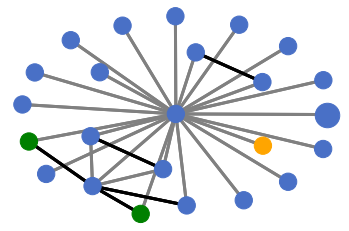

In [17]:
node_indices = torch.where(dataset[0].test_mask)[0].tolist()
from dig.xgraph.method.pgexplainer import PlotUtils
plotutils = PlotUtils(dataset_name='ba_shapes', is_show=True)
data = dataset[0]
node_idx = 50
with torch.no_grad():
    walks, masks, related_preds = \
        explainer(data.x, data.edge_index, node_idx=node_idx, y=data.y, top_k=5)

explainer.visualization(data, edge_mask=masks[0], top_k=5, plot_utils=plotutils, node_idx=node_idx)

### Metric results

In [18]:
top_k = 5
undirected_graph = True
# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector
x_collector = XCollector()

### Run explainer on the given model and dataset
index = -1
node_indices = torch.where(dataset[0].test_mask * dataset[0].y != 0)[0].tolist()
top_k = top_k if not undirected_graph else top_k * 2

for i, data in enumerate(dataloader):
    for j, node_idx in enumerate(node_indices):
        index += 1
        data.to(device)

        if torch.isnan(data.y[0].squeeze()):
            continue

        with torch.no_grad():
            walks, masks, related_preds = \
                explainer(data.x, data.edge_index, node_idx=node_idx, y=data.y, top_k=top_k)
            masks = [mask.detach() for mask in masks]
        x_collector.collect_data(masks, related_preds)

        # if you only have the edge masks without related_pred, please feed sparsity controlled mask to
        # obtain the result: x_processor(data, masks, x_collector)
        if index >= 99:
            break

    if index >= 20:
        break


print(f'Fidelity: {x_collector.fidelity:.4f}\n'
      f'Fidelity_inv: {x_collector.fidelity_inv:.4f}\n'
      f'Sparsity: {x_collector.sparsity:.4f}')

Fidelity: -0.0039
Fidelity_inv: 0.0636
Sparsity: 0.8829
